# Conditional likelihoods of trajectories

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from scipy import stats, interpolate
from numba import guvectorize,float64

import os
import glob

In [2]:
matplotlib.rc_file_defaults()

In [3]:
from analyzer import analyzer

(50, 300000)

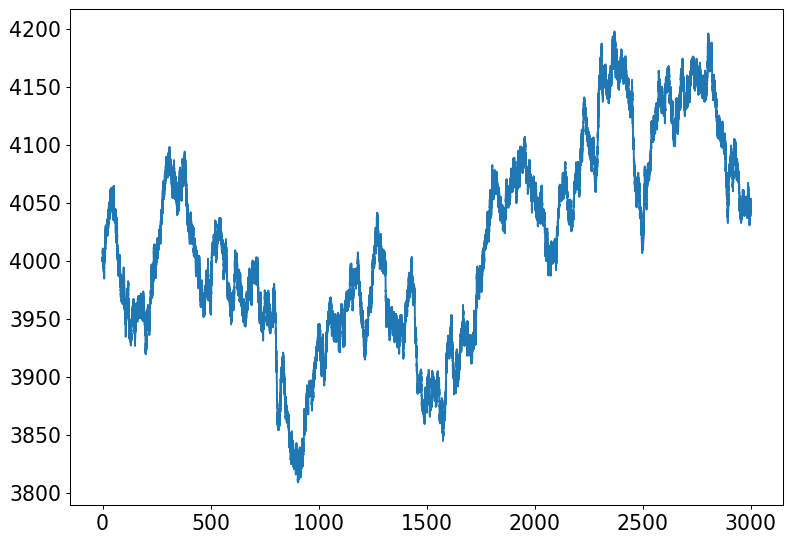

In [30]:
import mutual_information
import importlib
importlib.reload(mutual_information)

sig = mutual_information.generate_signals()

plt.plot(sig['timestamps'][0], sig['components']['S'][0])
sig['timestamps'].shape

In [85]:
run = 3
paths = glob.glob(os.path.expandvars('$HOME/run{}/*'.format(run)))
mutual_informations = np.array([np.load(p) for p in paths])

In [88]:
mutual_informations[0,0]

array([[ 2.02629355e-02,  2.74169029e+00,  5.22321624e+00, ...,
         2.49735400e+03,  2.50021684e+03,  2.50293766e+03],
       [-9.52878844e-05, -1.01136794e-02, -8.61234870e-03, ...,
         2.90297430e+00,  2.90049866e+00,  2.85361749e+00]])

In [89]:
mutual_informations.shape

(50, 50, 2, 1000)

In [90]:
num_s, num_r, _, length = mutual_informations.shape

In [91]:
x = np.linspace(np.max(mutual_informations[:,:,0,0]),np.min(mutual_informations[:,:,0,-1]),1000)
mi = np.zeros((num_s * num_r, len(x)))
for i, old in enumerate(np.reshape(mutual_informations, (-1, 2, length))):
    mi[i] = np.interp(x, old[0], old[1])
mi = np.reshape(mi, (num_s, num_r, -1))
mi_mean = np.mean(mi, axis=(0,1))

In [92]:
def subset_indices(num_responses, subset_signals, subset_responses):
    assert subset_responses <= num_responses
    indices = np.zeros((subset_signals * subset_responses, 2), dtype=int)
    for s in range(subset_signals):
        for r in range(subset_responses):
            indices[s*subset_responses + r] = [s, r]
    return indices.T
    

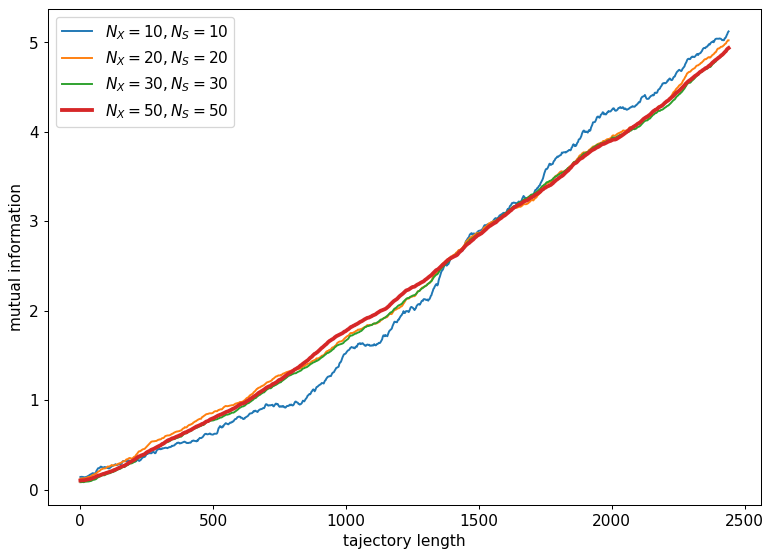

In [108]:
for s, r in [(10, 10),(20, 20), (30, 30)]:
    indices = subset_indices(num_r, s, r)
    subset_mean = np.mean(mi[indices[0], indices[1]], axis=0)
    plt.plot(x, subset_mean, label='$N_X={}, N_S={}$'.format(r, s))
plt.plot(x, mi_mean, label='$N_X={}, N_S={}$'.format(num_r, num_s), linewidth=3)
plt.legend();
plt.ylabel('mutual information')
plt.xlabel('tajectory length');

In [131]:
def mut_inf(lamda, rho):
    return lamda/2 * (np.sqrt(1 + rho/lamda) - 1)
from scipy.optimize import curve_fit
def linear(t, inf_rate, offset):
    return t * inf_rate + offset

(rate, offset), _ = curve_fit(linear, x, mi_mean, sigma=np.exp(-x/2500))
theoretical_rate = mut_inf(0.005, 0.005)
print(rate, theoretical_rate * 2)

0.0020861105271501312 0.0020710678118654757


In [128]:
numerical = np.array([0.        , 0.19539714, 0.25458964, 0.31318882, 0.37144066,
       0.42948886, 0.48741757, 0.54527612, 0.60309347, 0.66088662,
       0.71866556, 0.77643614, 0.83420182, 0.89196462, 0.94972572,
       1.00748583, 1.06524535, 1.12300453, 1.18076351, 1.23852237,
       1.29628116, 1.35403991, 1.41179863, 1.46955734, 1.52731605,
       1.58507474, 1.64283344, 1.70059213, 1.75835082, 1.81610952,
       1.87386821, 1.9316269 , 1.98938559, 2.04714428, 2.10490297,
       2.16266166, 2.22042035, 2.27817904, 2.33593773, 2.39369642,
       2.45145511, 2.5092138 , 2.56697249, 2.62473118, 2.68248988,
       2.74024857, 2.79800726, 2.85576595, 2.91352464, 2.97128333,
       3.02904202, 3.08680071, 3.1445594 , 3.20231809, 3.26007678,
       3.31783547, 3.37559416, 3.43335285, 3.49111154, 3.54887023,
       3.60662892, 3.66438762, 3.72214631, 3.779905  , 3.83766369,
       3.89542238, 3.95318107, 4.01093976, 4.06869845, 4.12645714,
       4.18421583, 4.24197452, 4.29973321, 4.3574919 , 4.41525059,
       4.47300928, 4.53076797, 4.58852666, 4.64628536, 4.70404405,
       4.76180274, 4.81956143, 4.87732012, 4.93507881, 4.9928375 ,
       5.05059619, 5.10835488, 5.16611357, 5.22387226, 5.28163095,
       5.33938964, 5.39714833, 5.45490702, 5.51266571, 5.5704244 ,
       5.6281831 , 5.68594179, 5.74370048, 5.80145917, 5.85921786])

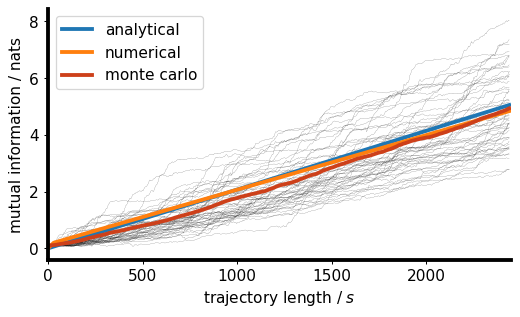

In [129]:
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'TeX Gyre Heros'})
for val in mi:
    plt.plot(x, np.mean(val, axis=0), linewidth=0.1, color='black')
plt.plot(x, theoretical_rate*x*2, label='analytical', linewidth=3)

numerical_x = np.arange(0, 3000, 30)
plt.plot(numerical_x, numerical, linewidth=3, label='numerical')

plt.plot(x, mi_mean, label='monte carlo'.format(num_r, num_s), linewidth=3, color='#CD401A')

plt.xlim(0,2450)

ax = plt.gca()
for pos in ['right', 'top']:
    ax.spines[pos].set_visible(False)
    
for pos in ['left', 'bottom']:
    ax.spines[pos].set_linewidth(3)

plt.ylabel('mutual information / nats')
plt.xlabel('trajectory length $/\\; s$')
plt.legend()

plt.gcf().set_size_inches(16.5/2.54, 9.0/2.54)
plt.savefig('poster_plot_3.pdf')

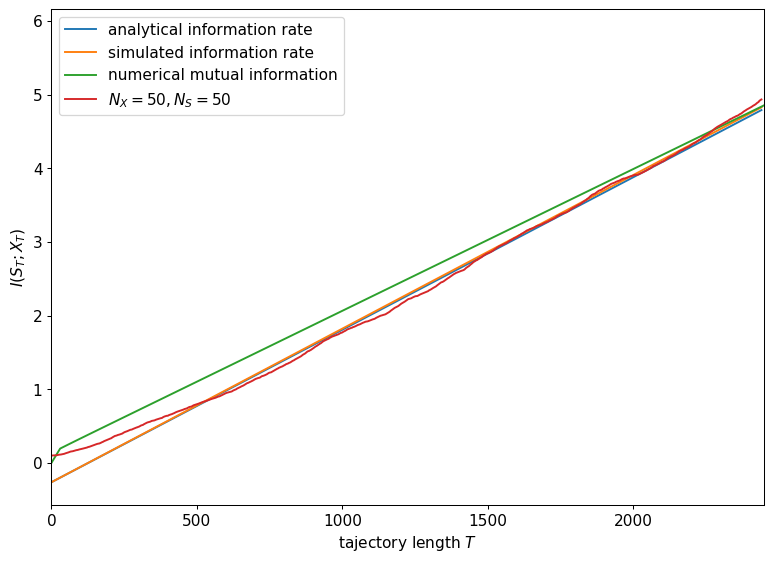

In [130]:
plt.plot(x, theoretical_rate*x*2+offset, label='analytical information rate')
plt.plot(x, linear(x, rate, offset), label='simulated information rate')
plt.plot(numerical_x, numerical, label='numerical mutual information')
plt.plot(x, mi_mean, label='$N_X={}, N_S={}$'.format(num_r, num_s))
plt.ylabel('$I(S_T;X_T)$')
plt.xlabel('tajectory length $T$')
plt.xlim(0,2450)
plt.legend();

(0, 4)

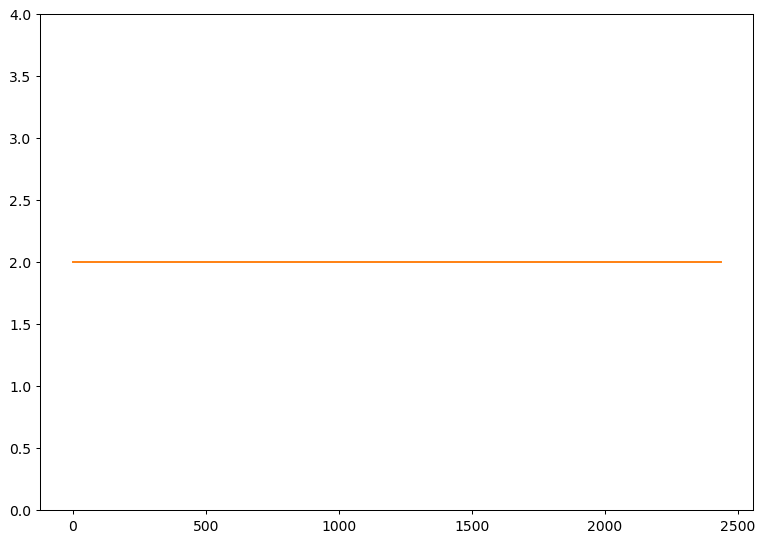

In [74]:
plt.plot(x, (mi_mean - offset) / theoretical_rate / x)
plt.plot(x, np.full_like(x, 2))
plt.ylim(0,4)

In [14]:
from pathlib import Path
signal = analyzer.load_trajectory(Path('/data/signal/sig1.traj'))

Define the reactions

In [16]:
from analyzer import stochastic_sim

reaction_k = np.array([0.005, 0.02])
reaction_reactants = np.array([[0], [1]])
reaction_products = np.array([[0, 1], [-1, -1]])

length = 100000
num_responses = 3

timestamps = np.zeros((num_responses, length))
trajectory = np.empty((num_responses, 1, length))
trajectory[...,0] = 1000.0
reaction_events = np.empty((num_responses, length), dtype='i4')

ext_components = signal['components']['S'].reshape((1,-1))
ext_timestamps = signal['timestamps']

In [17]:
stochastic_sim.simulate(timestamps, trajectory, ext_components, ext_timestamps,
                            reaction_k, reaction_reactants, reaction_products, reaction_events)

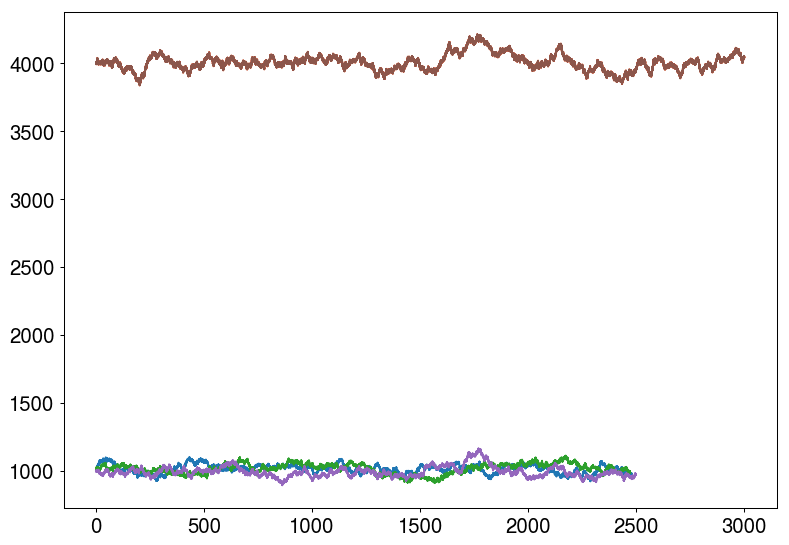

In [18]:
for t, x in zip(timestamps, trajectory):
    plt.plot(t, x[0])
    plt.plot(ext_timestamps, ext_components[0])

In [45]:
timestamps

array([[0.00000000e+00, 3.76423937e-02, 3.90474676e-02, ...,
        2.49852658e+03, 2.49853016e+03, 2.49855508e+03],
       [0.00000000e+00, 2.89235474e-02, 4.05906440e-02, ...,
        2.49472226e+03, 2.49476384e+03, 2.49478347e+03],
       [0.00000000e+00, 1.90082337e-02, 3.41506442e-02, ...,
        2.51001662e+03, 2.51005544e+03, 2.51009575e+03]])

In [82]:
responses = []
for i in range(5):
    analyzer.simulate_trajectory('response.inp', '/data/response.traj', ['/data/signal/sig1.traj'], seed=i)
    responses.append(analyzer.load_trajectory(Path('/data/response.traj')))

In [83]:
responses[0]

{'components': {'X': array([ 999.,  998.,  999., ..., 1050., 1049., 1050.])},
 'reaction_events': array([1, 1, 0, ..., 1, 1, 0]),
 'reactions': [{'k': 0.005, 'reactants': ['S']},
  {'k': 0.02, 'reactants': ['X']}],
 'timestamps': array([1.30704661e-02, 1.69024764e-02, 2.87210721e-02, ...,
        2.48276210e+03, 2.48278976e+03, 2.48291028e+03])}

In [84]:
signal['components']['S'].mean() * 0.005, responses[0]['components']['X'].mean() * 0.02

(20.09082079405963, 20.171788)

In [85]:
responses[0]['reactions']

[{'k': 0.005, 'reactants': ['S']}, {'k': 0.02, 'reactants': ['X']}]

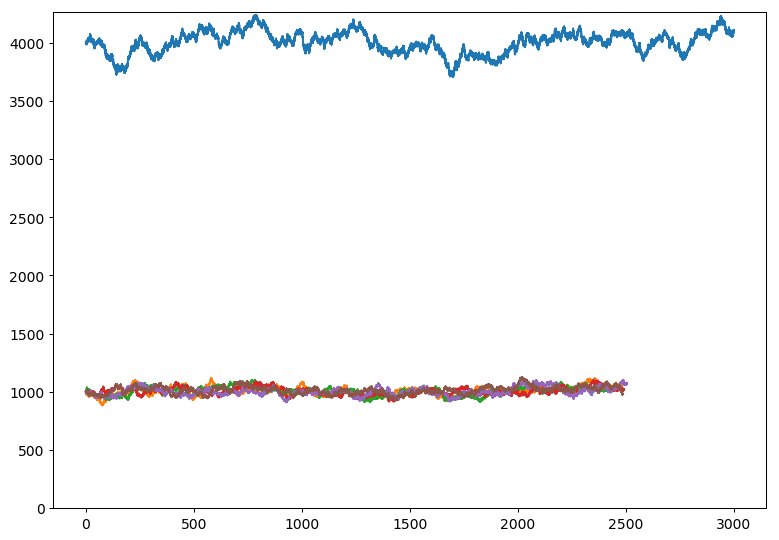

In [102]:
plt.plot(signal['timestamps'], signal['components']['S'])
plt.ylim(0,None)
for response in responses:
    plt.plot(response['timestamps'], response['components']['X'])

In [101]:
variance = []
for i in range(30):
    signal = analyzer.load_trajectory(Path('/data/signal/sig{}.traj'.format(i)))
    variance.append(np.var(signal['components']['S'][::1000]))
np.array(variance).std()

1819.5531275592243

In [106]:
from analyzer.ornstein_uhlenbeck import generate
corr_time = 1
diff_const = 0.285
generate(np.linspace(0, 1000, 1000000), 0, corr_time, diff_const, mean=0)[::1000].var(), corr_time * diff_const

(0.27693800082838527, 0.285)

In [97]:
signal['components']['S'][::10000]

array([4000.        , 3872.1097009 , 3882.27364466, 3883.30806235,
       4059.51643523, 4080.95057292, 4051.11453995, 4136.9556344 ,
       4170.45818198, 3993.70973701, 4084.1138415 , 4020.07931974,
       4097.94836113, 4073.5102347 , 3925.27479799, 3946.32393728,
       4056.36082964, 3719.61015118, 3872.26306693, 3813.24658659,
       4011.9262731 , 3999.73391582, 4048.91473388, 4037.87627053,
       3995.96850478, 4074.7145511 , 3933.02383754, 4001.23749819,
       4010.11003992, 4124.67572393])

In [90]:
import importlib
importlib.reload(analyzer)
importlib.reload(analyzer.ornstein_uhlenbeck);